In [ ]:
import numpy as np
from scipy.optimize import linprog

import random
from itertools import product

from matplotlib import pyplot as plt

from tqdm import trange

: 

In [ ]:
def place_at_bin(arr, N):
    max_choice = N - arr.sum()
    i = random.randint(0, max_choice)
    index = random.choice(np.where(arr == 0)[0])
    arr[index] = i


def generate_a(N, l):
    A = np.zeros((l, l))
    i = 0
    while i < l:
        while A[:, i].sum() != N:
            place_at_bin(A[:, i], N)
        # check for any repetitions
        for j in range(i):
            if np.all(A[:, j] == A[:, i]):
                A[:, i] = 0
                i -= 1
        i += 1
    return A / N


def initialize_AI(N, l):
    return generate_a(N, l)

: 

In [80]:
def solve_rmp(AI, cI, marginal):
    result = linprog(cI, A_eq=AI, b_eq=marginal, bounds=(0, None))
    if result.x is None:
        print(result)
        print(AI)
        print(cI)
        print(marginal)
    return result.x


def solve_dual(AI, cI, marginal):
    c_dual = -marginal  # because linprog does minimization
    result = linprog(c_dual, A_ub=AI.T, b_ub=cI,
                     bounds=[(None, 0) for _ in cI])
    return result.x


def mutate_parent(parent, l):
    child = parent.copy()
    change_index = random.choice(np.where(parent > 0)[0])
    direction = random.choice([-1, 1])
    destination = max(min(l-1, change_index + direction), 0)
    child[destination] += parent[change_index]
    child[change_index] -= parent[change_index]
    child /= child.sum()
    return child


def compute_cost(lambd, N, cost_matrix: np.ndarray):
    return (N**2/2 * lambd.T @ cost_matrix @ lambd -
            N/2 * cost_matrix.diagonal().T @ lambd)


def genetic_column_generation(
        N,
        l,
        beta,
        pair_potential,
        coordinates_of_sites,
        marginal,
        maxiter,
        maxsamples
):
    a, b = coordinates_of_sites
    x = y = np.linspace(a, b, l)
    X, Y = np.meshgrid(x, y, indexing='ij')
    cost_matrix = pair_potential(X, Y)

    # AI = np.eye(l)
    # AI = np.random.randn(l, l)
    # AI /= AI.sum(axis=0)
    AI = initialize_AI(N, l)
    print('Initialized A_I')

    cI = np.empty(l)
    for j in range(AI.shape[1]):
        cI[j] = compute_cost(AI[:, j], N, cost_matrix)
    samples = 0
    iter = 0
    gain = -1

    with trange(maxiter) as t:
        for i in t:
            print(f"iteration {i}")
            alpha_I = solve_rmp(AI, cI, marginal)
            y_star = solve_dual(AI, cI, marginal)

            while gain <= 0 and samples <= maxsamples:
                # Select a random active column of AI
                parent_index = random.choice(np.where(alpha_I > 0)[0])
                parent = AI[:, parent_index]
                child = mutate_parent(parent, l)
                c_child = compute_cost(child, N, cost_matrix)

                # Calculate gain from adding the child column
                gain = np.dot(child.T, y_star) - c_child

                samples += 1

            # Update AI and cI with the new child column if there's a positive gain
            if gain > 0:
                AI = np.hstack((AI, child[:, np.newaxis]))
                # cI = np.hstack((cI, c_child))
                cI = np.append(c_child)
                if AI.shape[1] > beta * l:
                    # Clear the oldest inactive columns
                    inactive_indices = np.where(alpha_I == 0)[0]
                    AI = np.delete(AI, inactive_indices[:l], axis=1)
                    # cI = np.delete(cI, inactive_indices[:l], axis=1)
                    cI = np.delete(cI, inactive_indices[:l])

            iter += 1

            t.set_postfix(samples=samples)

    return AI, alpha_I  # Return the final set of columns and configuration


In [81]:
N = 10  # Number of marginals
l = 100  # Number of sites
beta = 5  # Hyperparameter for controlling the maximum columns
maxiter = 5000  # Maximum number of iterations
# maxsamples = 1000  # Maximum number of samples for mutations

grid_points = np.arange(1, l+1)

marginal = 0.2 + np.power(np.sin(np.pi * grid_points / (l+1)), 2)
marginal /= marginal.sum()


def pair_potential(x, y, eps=0.1):
    "Use regulatized Coulomb interaction"
    return 1 / np.sqrt(eps**2 + np.power(x - y, 2))

In [82]:
print("1-DIMENSIONAL SETTING.")
print(f"Number of marginals {N=}")
print(f"Number of grid points {l=}")
print(f"Hyperparameter for controlling the maximum columns {beta=}")
print(f"Maximum number of iterations {maxiter=}")
print(f"First 6 gridpoints {grid_points[:6]}")
print(f"Last 6 gridpoints {grid_points[-6:]}")
print(f"Marginal {marginal[:5]}")

1-DIMENSIONAL SETTING.
Number of marginals N=10
Number of grid points l=20
Hyperparameter for controlling the maximum columns beta=5
Maximum number of iterations maxiter=1000
First 6 gridpoints [1 2 3 4 5 6]
Last 6 gridpoints [15 16 17 18 19 20]
Marginal [0.01532508 0.01978487 0.02677621 0.0356779  0.04569896]


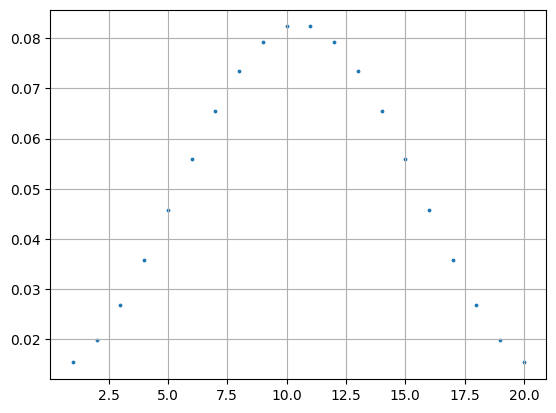

In [83]:
plt.scatter(grid_points, marginal, s=3)
plt.grid()

In [84]:
ai, alpha = genetic_column_generation(
    N, l, beta, pair_potential, (0, 1), marginal, maxiter, 100000)

ValueError: Invalid input for linprog: c must be a 1-D array and must not have more than one non-singleton dimension

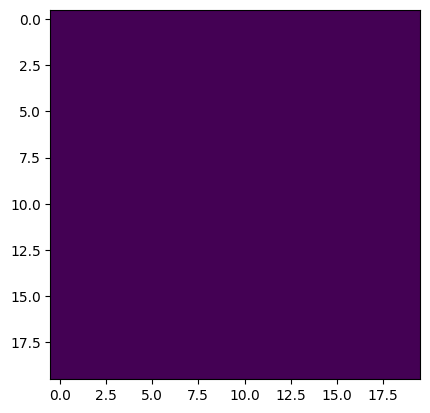

In [70]:
gamma = ai.T @ alpha
print(f"{gamma.shape=}")
print(gamma)

plt.scatter(grid_points, gamma)
plt.show()

In [73]:
ci[:, 0]

array([450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450.])